# Video Games Sales Prediction

In [ ]:
!pip install xgboost==1.7.0
!pip install pyarrow

In [48]:
import matplotlib.pyplot as plt
import csv
import random
import numpy as np
import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql import *
from pyspark.context import SparkContext

In [3]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import RandomForestRegressor
from xgboost.spark import SparkXGBRegressor

In [ ]:
# sc=SparkContext(master="local[*]")

# spark = SparkSession \
#         .builder \
#         .appName("Python Spark SQL basic example") \
#         .config("spark.some.config.option", "some-value") \
#         .getOrCreate()

# Spark ML

In [4]:
df = spark.read.format("csv").option("header","true").load('data/Video_Games_Sales.csv')

## EDA

In [5]:
print("df shape:", (df.count(), len(df.columns)))

df shape: (16719, 16)


In [6]:
# Print the schema of df
df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Year_of_Release: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- NA_Sales: string (nullable = true)
 |-- EU_Sales: string (nullable = true)
 |-- JP_Sales: string (nullable = true)
 |-- Other_Sales: string (nullable = true)
 |-- Global_Sales: string (nullable = true)
 |-- Critic_Score: string (nullable = true)
 |-- Critic_Count: string (nullable = true)
 |-- User_Score: string (nullable = true)
 |-- User_Count: string (nullable = true)
 |-- Developer: string (nullable = true)
 |-- Rating: string (nullable = true)



some N/A's appear as strings, so we'll replace them with NULL

In [7]:
df = df.select([when(col(c) == "N/A", "").otherwise(col(c)).alias(c) for c in df.columns])

In [8]:
na_counts = df.select([sum(when(isnull(c) | isnan(c) | (col(c) == ""), 1).otherwise(0)).alias(c) for c in df.columns])
na_counts.show()

+----+--------+---------------+-----+---------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+---------+------+
|Name|Platform|Year_of_Release|Genre|Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|Critic_Score|Critic_Count|User_Score|User_Count|Developer|Rating|
+----+--------+---------------+-----+---------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+---------+------+
|   2|       0|            269|    2|       54|       0|       0|       0|          0|           0|        8582|        8582|      9129|      9129|     6623|  6769|
+----+--------+---------------+-----+---------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+---------+------+



__Name__: this column has only 2 missing valus, we can easily drop them.

In [9]:
df = df.filter(df['Name'].isNotNull())

__Year of relese__: is one of the core components for this reaserch. It cant be replaced with an average or even an everage span of years from the console activity years because most of the used platforms used to release games for more than 7 years. Plus, more than 40% are also missing critics scores. Missing values will be dropped.

In [10]:
platforms = df.filter(df['Year_of_Release'].isNull()).groupBy('Platform').agg({'Platform': 'count'}).select('Platform').distinct()
platforms.show()

+--------+
|Platform|
+--------+
|      PC|
|     PS3|
|      PS|
|     PS2|
|     3DS|
|      GB|
|     N64|
|     PSP|
|    2600|
|    X360|
|     GBA|
|     Wii|
|      GC|
|     PSV|
|      XB|
|      DS|
+--------+



In [11]:
df = df.filter(df['Year_of_Release'].isNotNull())

Also 2020 has only one record with lots of missing data, it will be removed. Same for 2017.

In [12]:
df = df.filter(df['Year_of_Release'] != 2020)
df = df.filter(df['Year_of_Release'] != 2017)

__Ratings__: The American game rating system is called ESRB (Entertainment Software Rating Board). 
It provides information about what's in a game or app so parents and consumers can make informed choices about which games are right for their family. More information can be found on the official website HERE.

Regarding the replacement of empty or missing values:
* Since the rating system was created on 1994, we will replace empty values only after 1994. 
* NA values from before 1994 will be filled with rating E since it was for evetyone. 
* NA Values after 1994 will be left as N/A.
* Scare values like Ao (Adults Only), RP (Rating Pending), K-A (Kids to Adults), EC (Early Childhood), and N/A (No Rating) will be replaced according to this mapping:

| Rating | Map | Description |
| ------ | ------ | ------ |
| EC | E | Early childhood |
| K-A | E | Kids to Adults, so basically everyone|
| AO | M | Adults Only |
| RP | E10+ | We checked the game rating online |
| N/A | NR | No Rating |

In [13]:
# replace scare values
df = df.withColumn('Rating', when(df['Rating'].isin('EC', 'K-A'), 'E')
                            .when(df['Rating'] == 'AO', 'M')
                            .when(df['Rating'].isin('RP'), 'E10+')
                            .when(df['Rating'].isNull(), 'NR')
                            .otherwise(df['Rating']))

In [14]:
df = df.withColumn('Rating', when(df['Rating'].isNull(), 'E').otherwise(df['Rating']))

__Developer__: Since this column has sub-important information for our reaserch, has ~40% missing data and 1723 unique string values it will be dropped.

In [15]:
nunique = df.agg(approx_count_distinct(df['Developer'])).collect()[0][0]
print("Number of unique values in the 'Developer' column: ", nunique)

23/03/05 11:14:10 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
Number of unique values in the 'Developer' column:  1723


In [16]:
result = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ["Developer"]]).collect()[0][0] / df.count()
print("Precentage of missing data in the 'Developer' column: ", '{:.2%}'.format(result))

Precentage of missing data in the 'Developer' column:  39.76%


In [17]:
df = df.drop("Developer")

__Publisher__: Since it has only 2 missing values it wont be dropped. Also this column may prove importent as a publisher has big role in game sales. we'll replace the missing values with __'Small_Publisher'__. Small publisher defined as companies that revenued less than 0.5M$ over a year in average.

In [18]:
df = df.withColumn("Publisher", when(col("Publisher").isNull(), "Small_Publisher").otherwise(col("Publisher")))

__User_Count & Critic_Count__: Since this values report no critic, thus will be filled with 0.

In [19]:
df = df.withColumn("User_Count", when(df["User_Count"].isNull(), 0).otherwise(df["User_Count"]))

In [20]:
df = df.withColumn("Critic_Count", when(df["Critic_Count"].isNull(), 0).otherwise(df["Critic_Count"]))

__Critic_Score and User_Score__: This columns may be crucial in our reasecrh, thus filling this NA's is important and should be handled with care.

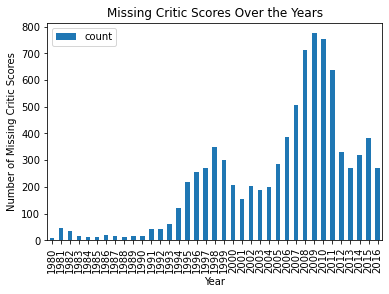

In [21]:
missing_scores = df.filter(col("Critic_Score").isNull()).groupBy("Year_of_Release").count()
missing_scores = missing_scores.toPandas()
missing_scores = missing_scores.set_index('Year_of_Release')
missing_scores = missing_scores.sort_index()

missing_scores.plot(kind='bar')
plt.title('Missing Critic Scores Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Missing Critic Scores')
plt.show()

In [22]:
years = df.select("Year_of_Release").distinct().rdd.flatMap(lambda x: x).collect()
years.sort()

average_score_map = []

for year in years:
    year = int(year)
    year_df = df.filter(col("Year_of_Release") == year)

    mean_Critic_Score = year_df.select(round(mean(col("Critic_Score")))).collect()[0][0] or 0.0
    mean_User_Score = year_df.select(round(mean(col("User_Score")))).collect()[0][0] or 0.0

    average_score_map.append({
        "Year": year,
        "Critic_Score": mean_Critic_Score,
        "Critics": year_df.filter(col("Critic_Score").isNotNull()).count(),
        "User_Score": mean_User_Score,
        "Users": year_df.filter(col("User_Score").isNotNull()).count()
    })
    
rdd = spark.sparkContext.parallelize(average_score_map)

# Convert the RDD to a DataFrame
scores_df = rdd.toDF(["Critic_Score", "Critics", "User_Score", "Users", "Year"])
scores_df.show(50)

+------------+-------+----------+-----+----+
|Critic_Score|Critics|User_Score|Users|Year|
+------------+-------+----------+-----+----+
|         0.0|      0|       0.0|    0|1980|
|         0.0|      0|       0.0|    0|1981|
|         0.0|      0|       0.0|    0|1982|
|         0.0|      0|       0.0|    0|1983|
|         0.0|      0|       0.0|    0|1984|
|        59.0|      1|       6.0|    1|1985|
|         0.0|      0|       0.0|    0|1986|
|         0.0|      0|       0.0|    0|1987|
|        64.0|      1|       2.0|    1|1988|
|         0.0|      0|       0.0|    0|1989|
|         0.0|      0|       0.0|    0|1990|
|         0.0|      0|       0.0|    0|1991|
|        85.0|      1|       8.0|    1|1992|
|         0.0|      0|       0.0|    0|1993|
|        69.0|      1|       6.0|    1|1994|
|         0.0|      0|       0.0|    0|1995|
|        90.0|      8|       8.0|    8|1996|
|        85.0|     17|       8.0|   18|1997|
|        82.0|     28|       9.0|   31|1998|
|        7

Up to 2000 scores have no meaning, because they are submitted by a too low percentage of the records and shouldn't have effect on the machines learning procces.
From 2000 onward we will fill the NaN values with Yearly averge. in that way we fill the NaN and still bearly effect the yearly distribution of scores.

In [23]:
result_df = scores_df.filter(col("Year") > 2000).show()

+------------+-------+----------+-----+----+
|Critic_Score|Critics|User_Score|Users|Year|
+------------+-------+----------+-----+----+
|        71.0|    326|       8.0|  257|2001|
|        69.0|    627|       8.0|  464|2002|
|        70.0|    585|       8.0|  516|2003|
|        69.0|    561|       8.0|  489|2004|
|        69.0|    655|       8.0|  583|2005|
|        67.0|    620|       7.0|  552|2006|
|        66.0|    692|       7.0|  629|2007|
|        66.0|    715|       7.0|  661|2008|
|        68.0|    651|       7.0|  614|2009|
|        67.0|    500|       7.0|  467|2010|
|        69.0|    500|       7.0|  501|2011|
|        73.0|    321|       7.0|  339|2012|
|        71.0|    273|       6.0|  304|2013|
|        71.0|    261|       7.0|  329|2014|
|        73.0|    225|       7.0|  297|2015|
|        73.0|    232|       7.0|  262|2016|
+------------+-------+----------+-----+----+



In [24]:
# Replace values when Year_of_Release is less than 2000
df = df.withColumn("Critic_Score", when(df["Year_of_Release"] < 2000, 0).otherwise(df["Critic_Score"]))
df = df.withColumn("Critic_Count", when(df["Year_of_Release"] < 2000, 0).otherwise(df["Critic_Count"]))
df = df.withColumn("User_Score", when(df["Year_of_Release"] < 2000, 0).otherwise(df["User_Score"]))
df = df.withColumn("User_Count", when(df["Year_of_Release"] < 2000, 0).otherwise(df["User_Count"]))

# Replace missing values
critic_score_mean = scores_df.filter(col("Year") > 2000).agg({"Critic_Score": "mean"}).collect()[0][0]
user_score_mean = scores_df.filter(col("Year") > 2000).agg({"User_Score": "mean"}).collect()[0][0]
df = df.withColumn("Critic_Score", when(df["Critic_Score"].isNull(), critic_score_mean).otherwise(df["Critic_Score"]))
df = df.withColumn("Critic_Count", when(df["Critic_Count"].isNull(), 0).otherwise(df["Critic_Count"]))
df = df.withColumn("User_Score", when(df["User_Score"].isNull(), user_score_mean).otherwise(df["User_Score"]))
df = df.withColumn("User_Count", when(df["User_Count"].isNull(), 0).otherwise(df["User_Count"]))

In [25]:
na_counts = df.select([sum(when(isnull(c) | isnan(c) | (col(c) == ""), 1).otherwise(0)).alias(c) for c in df.columns])
na_counts.show()

+----+--------+---------------+-----+---------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+------+
|Name|Platform|Year_of_Release|Genre|Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|Critic_Score|Critic_Count|User_Score|User_Count|Rating|
+----+--------+---------------+-----+---------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+------+
|   0|       0|              0|    0|        0|       0|       0|       0|          0|           0|           0|           0|         0|         0|     0|
+----+--------+---------------+-----+---------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+------+



In [26]:
# custom function to convert the data type of DataFrame columns
def convertColumn(df, names, newType):
  for name in names: 
     df = df.withColumn(name, df[name].cast(newType))
  return df 

columns = ['Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']

# Conver the df columns to int/float
df = convertColumn(df, columns, "float")

In [27]:
# Print the schema of df
df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Year_of_Release: float (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- NA_Sales: float (nullable = true)
 |-- EU_Sales: float (nullable = true)
 |-- JP_Sales: float (nullable = true)
 |-- Other_Sales: float (nullable = true)
 |-- Global_Sales: float (nullable = true)
 |-- Critic_Score: float (nullable = true)
 |-- Critic_Count: float (nullable = true)
 |-- User_Score: float (nullable = true)
 |-- User_Count: float (nullable = true)
 |-- Rating: string (nullable = true)



In [28]:
def save_csv(temp_path, target_path, df):
    df.coalesce(1).write.mode("overwrite").option("header", "true").csv(temp_path)
    Path = sc._gateway.jvm.org.apache.hadoop.fs.Path

    # get the part file generated by spark write
    fs = Path(temp_path).getFileSystem(sc._jsc.hadoopConfiguration())
    csv_part_file = fs.globStatus(Path(temp_path + "/part*"))[0].getPath()

    # move and rename the file
    fs.rename(csv_part_file, Path(target_path))
    fs.delete(Path(temp_path), True)

In [29]:
temp_path = "data/__temp"
target_path = "data/Video_Games_Sales_Fixed.csv"

save_csv(temp_path, target_path, df)

## Models

In [30]:
def get_train_test_data(df, year):
    train_df = df.filter(df['Year_of_Release'] < year)
    test_df = df.filter(df['Year_of_Release'] == year)
    return train_df, test_df

In [31]:
def df_preProcess(fixed_df): 
    # Models Pre-Process
    # ----------------

    # String Indexer
    indexer = StringIndexer(inputCols=['Platform', 'Genre', 'Publisher', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Rating'], 
                                    outputCols=['Platform_numeric', 'Genre_numeric', 'Publisher_numeric', 'Critic_Score_numeric',
                                                'Critic_Count_numeric', 'User_Score_numeric', 'User_Count_numeric', 'Rating_numeric'])
    indexer_fitted = indexer.fit(fixed_df)
    df_indexed = indexer_fitted.transform(fixed_df)

    # OneHotEncoder
    encoder = OneHotEncoder(inputCols=['Platform_numeric', 'Genre_numeric', 'Publisher_numeric', 'Critic_Score_numeric',
                                               'Critic_Count_numeric', 'User_Score_numeric', 'User_Count_numeric', 'Rating_numeric'], 
                                   outputCols=['Platform_Vec', 'Genre_Vec', 'Publisher_Vec', 'Critic_Score_Vec',
                                               'Critic_Count_Vec', 'User_Score_Vec', 'User_Count_Vec', 'Rating_Vec'])
    model = encoder.fit(df_indexed)
    encoded = model.transform(df_indexed)

    # VectorAssembler
    vectorAssembler = VectorAssembler(inputCols = ['Platform_Vec', 'Genre_Vec', 'Publisher_Vec', 'Critic_Score_Vec',
                                               'Critic_Count_Vec', 'User_Score_Vec', 'User_Count_Vec', 'Rating_Vec'], 
                                  outputCol = 'features')
    v_df = vectorAssembler.transform(encoded)
    v_df = v_df.select(['Name', 'Year_of_Release', 'features', 'Global_Sales'])
    
    return v_df

In [60]:
def run_model(df, year):
    models_results = []
 
    # Train Test split  
    train_df, test_df = get_train_test_data(df, year)

    # Running Models
    # ---------------

    # Linear Regression
    lr = LinearRegression(featuresCol='features', labelCol='Global_Sales')
    lr_model = lr.fit(train_df)
    lr_predictions = lr_model.transform(test_df)
    lr_prediction_rows = lr_predictions.select("prediction").collect()
    lr_prediction_list = []
    for row in lr_prediction_rows:
        lr_prediction_list.append(row.asDict()['prediction'])
    lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Global_Sales", metricName="rmse")
    rmse = lr_evaluator.evaluate(lr_predictions)
        
    # update models_results data
    models_results.append({
        "model": 'LinearRegression',
        "year": year,
        "rmse": float(rmse),
        "predictions": lr_prediction_list
    })
    
    # Ridge Regression
    ridge = LinearRegression(featuresCol='features', labelCol='Global_Sales', regParam=0.2, elasticNetParam=0)
    ridge_model = ridge.fit(train_df)
    ridge_predictions = ridge_model.transform(test_df)
    ridge_prediction_rows = ridge_predictions.select("prediction").collect()
    ridge_prediction_list = []
    for row in ridge_prediction_rows:
        ridge_prediction_list.append(row.asDict()['prediction'])
    ridge_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Global_Sales", metricName="rmse")
    rmse = ridge_evaluator.evaluate(ridge_predictions)
        
    # update models_results data
    models_results.append({
        "model": 'RidgeRegression',
        "year": year,
        "rmse": float(rmse),
        "predictions": ridge_prediction_list
    })
    
    # Lasso Regression
    lasso = LinearRegression(featuresCol='features', labelCol='Global_Sales', regParam=0.2, elasticNetParam=1)
    lasso_model = lasso.fit(train_df)
    lasso_predictions = lasso_model.transform(test_df)
    lasso_prediction_rows = lasso_predictions.select("prediction").collect()
    lasso_prediction_list = []
    for row in lasso_prediction_rows:
        lasso_prediction_list.append(row.asDict()['prediction'])
    lasso_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Global_Sales", metricName="rmse")
    rmse = lasso_evaluator.evaluate(lasso_predictions)
        
    # update models_results data
    models_results.append({
        "model": 'LassoRegression',
        "year": year,
        "rmse": float(rmse),
        "predictions": lasso_prediction_list
    })
    
    # Decision Tree Regression
    dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'Global_Sales')
    dt_model = dt.fit(train_df)
    dt_predictions = dt_model.transform(test_df)
    dt_prediction_rows = dt_predictions.select("prediction").collect()
    dt_prediction_list = []
    for row in dt_prediction_rows:
        dt_prediction_list.append(row.asDict()['prediction'])
    dt_evaluator = RegressionEvaluator(labelCol="Global_Sales", predictionCol="prediction", metricName="rmse")
    rmse = dt_evaluator.evaluate(dt_predictions)

    # update models_results data
    models_results.append({
        "model": 'DecisionTreeRegressor',
        "year": year,
        "rmse": float(rmse),
        "predictions": dt_prediction_list
    })

    # Gradient-boosted tree regression
    gbt = GBTRegressor(featuresCol = 'features', labelCol = 'Global_Sales', maxIter=10)
    gbt_model = gbt.fit(train_df)
    gbt_predictions = gbt_model.transform(test_df)
    gbt_prediction_rows = gbt_predictions.select("prediction").collect()
    gbt_prediction_list = []
    for row in gbt_prediction_rows:
        gbt_prediction_list.append(row.asDict()['prediction'])
    gbt_evaluator = RegressionEvaluator(labelCol="Global_Sales", predictionCol="prediction", metricName="rmse")
    rmse = gbt_evaluator.evaluate(gbt_predictions)

    # update models_results data
    models_results.append({
        "model": 'GBTRegressor',
        "year": year,
        "rmse": float(rmse),
        "predictions": gbt_prediction_list
    })
    
    # Random Forest regression
    rf = RandomForestRegressor(featuresCol="features", labelCol="Global_Sales", numTrees=10, maxDepth=5)
    rf_model = rf.fit(train_df)
    rf_predictions = rf_model.transform(test_df)
    rf_prediction_rows = rf_predictions.select("prediction").collect()
    rf_prediction_list = []
    for row in rf_prediction_rows:
        rf_prediction_list.append(row.asDict()['prediction'])
    rf_evaluator = RegressionEvaluator(labelCol="Global_Sales", predictionCol="prediction", metricName="rmse")
    rmse = rf_evaluator.evaluate(rf_predictions)

    # update models_results data
    models_results.append({
        "model": 'RandomForestRegressor',
        "year": year,
        "rmse": float(rmse),
        "predictions": rf_prediction_list
    })

    # XGBoost regression
    xgb_regressor = SparkXGBRegressor(features_col="features", label_col="Global_Sales")
    xgb_model = xgb_regressor.fit(train_df)
    xgb_predictions = xgb_model.transform(test_df)
    xgb_predictions_rows = xgb_predictions.select("prediction").collect()
    xgb_prediction_list = []
    for row in xgb_predictions_rows:
        xgb_prediction_list.append(row.asDict()['prediction'])
    xgb_evaluator = RegressionEvaluator(labelCol="Global_Sales", predictionCol="prediction", metricName="rmse")
    rmse = xgb_evaluator.evaluate(xgb_predictions)
    
    # update model data
    models_results.append({
        "model": 'SparkXGBRegressor',
        "year": year,
        "rmse": float(rmse),
        "predictions": xgb_prediction_list
    })
    
    # create a DataFrame from the RDD
    model_df = spark.createDataFrame(models_results)    
    model_df = model_df.withColumn("predictions_str", concat_ws(",", col("predictions")))
    model_df = model_df.drop("predictions")
    
    # write the DataFrame to a CSV file
    temp_path = "results/__temp"
    file_name = f'results/{year}.csv'

    save_csv(temp_path, file_name, model_df)

# Kafka

In [33]:
from confluent_kafka import Producer, Consumer, KafkaError
import json

## Create Topics

In [35]:
!/usr/local/kafka/kafka_2.13-3.2.1/bin/kafka-topics.sh --create --bootstrap-server localhost:9092 --replication-factor 1 --partitions 1 --topic salesHistory

Created topic salesHistory.


In [36]:
!/usr/local/kafka/kafka_2.13-3.2.1/bin/kafka-topics.sh --create --bootstrap-server localhost:9092 --replication-factor 1 --partitions 1 --topic predictions

Created topic predictions.


## Sales History Data

In [37]:
# read sales history data
with open('data/Video_Games_Sales_Fixed.csv', 'r') as f:
    # Read the lines of the file
    lines = f.readlines()

    sales_history_data = {}
    counter = 0

    # Iterate over the lines
    for line in lines:
        # save each line in a dict
        sales_history_data[counter] = line.replace("\n","")
        counter += 1

In [38]:
# convert sales_history_data from dict to pyspark df
def dict_to_df(data):    
    # split the values of the dictionary into a list of strings
    rows = list(data.values())

    # split the header string into a list of column names
    header = rows[0].split(',')

    # limit the number of columns to 15
    header = header[:15]
    rows = [row.split(',')[:15] for row in rows[1:]]

    # create a PySpark DF by passing list of tuples, where each tuple contains the column values for a given row
    df_Fixed = spark.createDataFrame(rows, header)
    
    return df_Fixed

## Save the data into a topic

In [39]:
# Define the Kafka producer configuration
producer_conf = {
        'bootstrap.servers': 'localhost:9092',
        'client.id': 'python-producer'
    }

In [40]:
def save_data(topic, data):
    # Create the Kafka producer instance
    producer = Producer(producer_conf)

    # Serialize the dictionary to a JSON string
    json_message = json.dumps(data)

    # Split the JSON string into smaller chunks
    chunk_size = 100
    for i in range(0, len(json_message), chunk_size):
        chunk = json_message[i:i + chunk_size]
        producer.produce(topic, key='chunk-{}'.format(i), value=chunk)

    producer.produce(topic, key='END', value='END')

    # Wait for any outstanding messages to be delivered and delivery report callbacks to be received
    producer.flush()

In [41]:
save_data('salesHistory', sales_history_data)

## Consumer

In [42]:
def consume_data(topic, consumer):
    # Subscribe to the topic
    consumer.subscribe([topic])

    # Initialize a variable to store the reassembled message
    reassembled_message = ''

    # Poll for messages
    while True:
        msg = consumer.poll(1.0)

        if msg is None: continue
            
        if msg.error():
            if msg.error().code() == KafkaError.PARTITION_EOF:
                print('Reached end of partition event for {} [{}] at offset {}'.format(
                    msg.topic(), msg.partition(), msg.offset()))
            else:
                print('Error while polling for messages: {}'.format(msg.error()))
            
        else:
            if (msg.value().decode('utf-8')) == 'END':
                break
            reassembled_message += msg.value().decode('utf-8')

    # Deserialize the reassembled message from JSON to a dictionary
    deserialized_message = json.loads(reassembled_message)
    # cast the dict keys into int
    sales_history_data_consumed = {int(key): value for key, value in deserialized_message.items()}

    # return the deserialized dictionary
    return sales_history_data_consumed

## Predictions

In [43]:
# consume sales history and produce prediction
def main_func(consumer, producer, topics, year):
    sales_history_data = consume_data(topics[0], consumer)
    
    # convert sales_history_data to pyspark df
    sales_history_df = dict_to_df(sales_history_data)
    
    # get the best prediction model
    v_df = df_preProcess(sales_history_df)
    v_df = convertColumn(v_df, ['Global_Sales'], "float")
    run_model(v_df, year)
    df_model = spark.read.format("csv").option("header","true").load(f'results/{year}.csv')
    
    # send to predictions topic
    for row in df_model.toJSON().collect():
        producer.produce(topic=topics[1], key=None, value=row)
    
    producer.flush()

In [61]:
random_id = random.randint(1, 10000)

# Define the Kafka consumer configuration
consumer_conf = {
    'bootstrap.servers': 'localhost:9092',
    'group.id': f'my_group{random_id}',
    'auto.offset.reset': 'earliest'
}

# Define the Kafka producer configuration
producer_conf = {
        'bootstrap.servers': 'localhost:9092',
        'client.id': 'python_producer'
}

# create the Kafka producer instance
p1 = Producer(producer_conf)

# create the Kafka consumer instance
c1 = Consumer(consumer_conf)

# choose prediction year
year = 2016

# run the consume loop function
main_func(c1, p1, ['salesHistory', 'predictions'], year)

Super Mario Land,GB,1989.0,Platform,Nintendo,10.83,2.71,4.18,0.42,18.14,0.0,0.0,0.0,0.0,NR
PASS 1
PASS 2
23/03/05 12:10:57 WARN Instrumentation: [e80558cd] regParam is zero, which might cause numerical instability and overfitting.
23/03/05 12:10:57 WARN Instrumentation: [e80558cd] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


[12:11:23] task 0 got new rank 0                                    (0 + 1) / 1]


PASS 3
PASS 4
